# Testing designer module

Basic data and imports.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import torch
import dgym as dg
import pyarrow.parquet as pq

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make designer.

In [2]:
import numpy as np
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

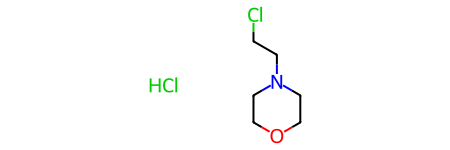

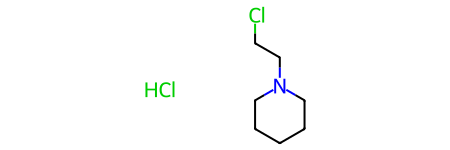

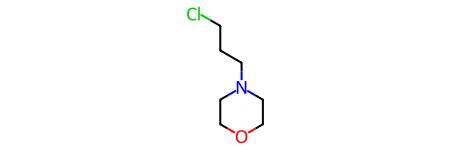

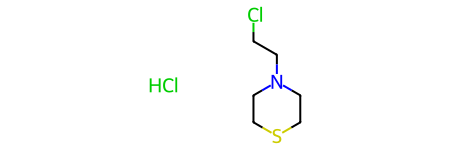

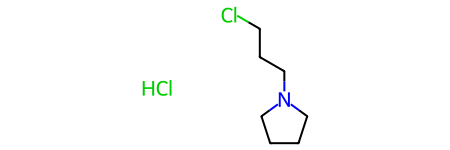

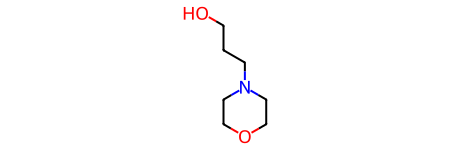

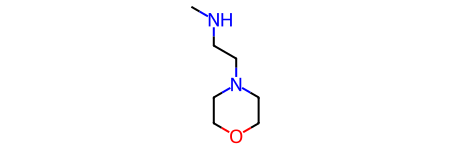

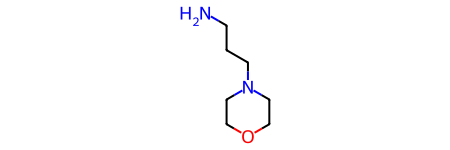

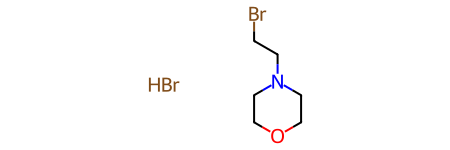

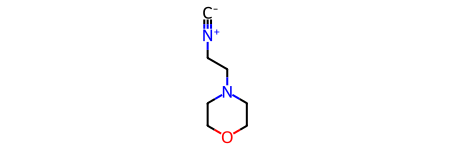

[None, None, None, None, None, None, None, None, None, None]

In [38]:
gen = designer.generator(deck[0].reactants[0])
[display(next(gen)) for _ in range(10)]

In [193]:
%%time
designer.reset_cache()


CPU times: user 723 ms, sys: 10.1 ms, total: 733 ms
Wall time: 93.5 ms


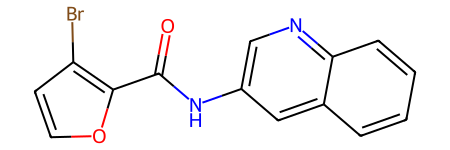

In [264]:
mol

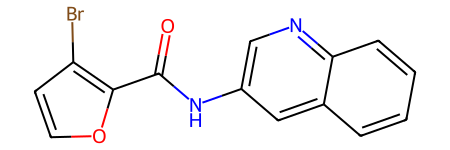

In [259]:
designer.design(deck[31], 1, temperature=0.05)[0]

CPU times: user 2.83 s, sys: 18.1 ms, total: 2.85 s
Wall time: 470 ms


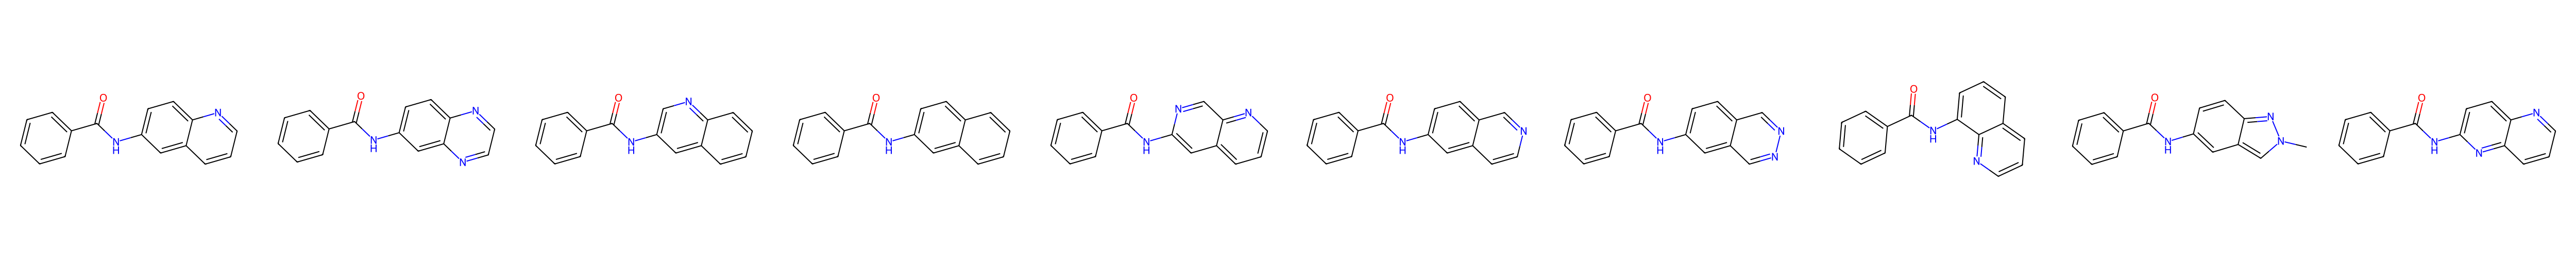

In [222]:
%%time
designer.reset_cache()
# analogs = designer.design(deck[0], 100, temperature = 0.7)
analogs = designer.design(deck[31], 10)
rdkit.Chem.Draw.MolsToGridImage([a.mol for a in analogs], molsPerRow=10, subImgSize=(500, 500))

In [148]:
# %%time
# designer.reset_cache()
# analogs = designer.design(deck[0], 100, temperature = 1.0)
# rdkit.Chem.Draw.MolsToGridImage([a.mol for a in analogs], molsPerRow=5)

In [139]:
from tqdm.notebook import tqdm

# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck))
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

random_molecules = []
for _ in tqdm(range(100)):
    
    # pick a molecule randomly from the deck
    initial_molecule = select_molecule(deck)

    # generate a few rounds of random molecules in REAL Space
    molecule = initial_molecule
    designer.reset_cache()
    for _ in range(3):
        molecule = designer.design(molecule, 1, temperature=1.0)[0]
    
    # generate a bunch of analogs
    molecules = designer.design(molecule, 100, temperature=1.0)
    
    random_molecules.extend(molecules)

  0%|          | 0/100 [00:00<?, ?it/s]

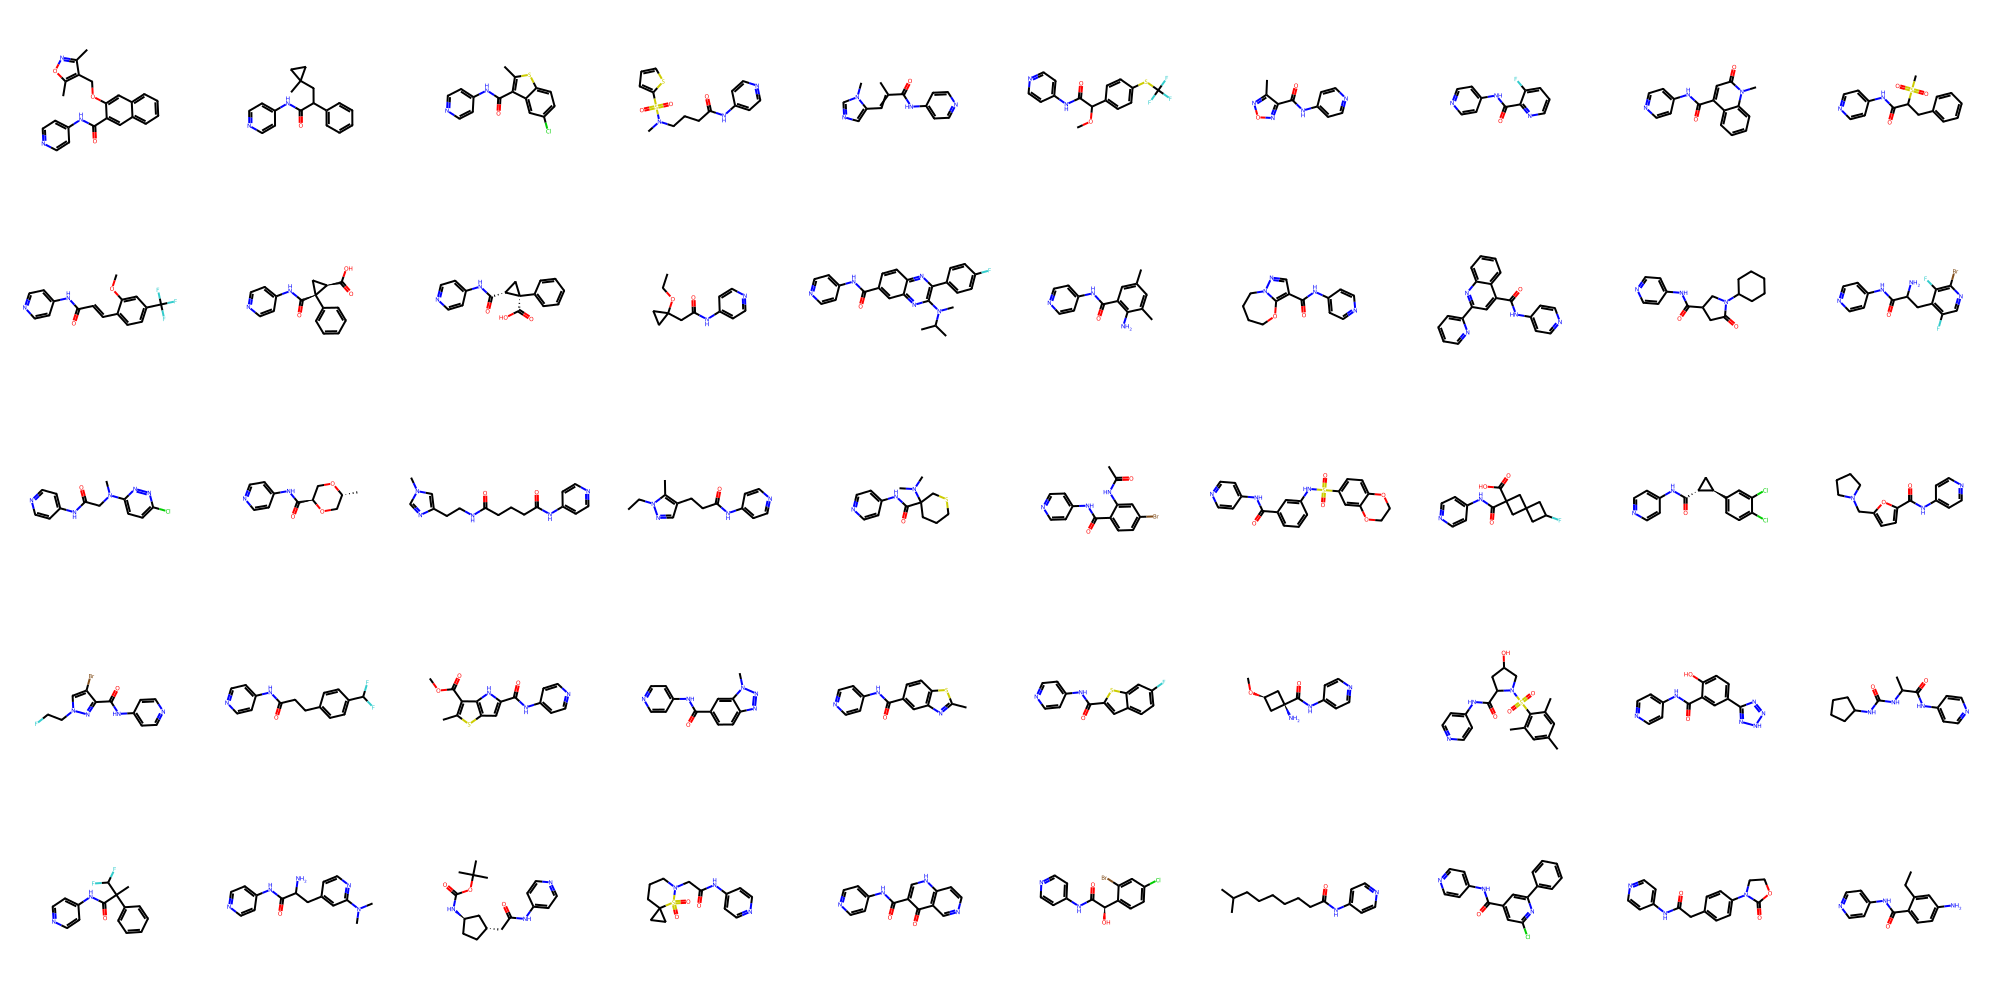

In [142]:
rdkit.Chem.Draw.MolsToGridImage([a.mol for a in random_molecules[5_000:]], molsPerRow=10)